In [1]:
# !pip install pandas transformers scikit-learn matplotlib seaborn sentencepiece accelerate -q
# !pip install protobuf

# import pandas as pd
# hate_yes_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_yes.csv')
# hate_no_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_no.csv')

# torch.set_default_tensor_type(torch.cuda.HalfTensor)

## **1. Datasets.**

In [2]:
import re
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
# from transformers import EncoderDecoderModel, BertTokenizer, DistilBertTokenizer
# from transformers import AutoModelForCausalLM

from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm

/Users/elenaericheva/ericheva_git/ccs_aisf/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# path to big hate data
hate_data = pd.read_csv('../data/raw/total_hate2.0.csv', index_col=0)
hate_data.head(2)

hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total_yes_2.0.csv', index_col=0)
hate_total_no_data =  pd.read_csv('../data/yes_no/hate_total_no_2.0.csv', index_col=0)

## **2. Choose model.**

In [6]:
# Available Gemma2 variants:

# google/gemma-2-2b - 2B parameter base model
# google/gemma-2-9b - 9B parameter base model
# google/gemma-2-2b-it - 2B instruction-tuned model
# google/gemma-2-9b-it - 9B instruction-tuned model

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

YOUR_NAME = "gemma-2-2b"

# CHANGED: Using Gemma2 model instead of DeBERTa
# IMPORTANT: Must use AutoModelForCausalLM, NOT AutoModelForMaskedLM
gemma_tokenizer = AutoTokenizer.from_pretrained(f"google/{YOUR_NAME}")
gemma_model = AutoModelForCausalLM.from_pretrained(
    f"google/{YOUR_NAME}",
    torch_dtype=torch.float32,  # Use half precision for efficiency
    device_map="auto"           # Automatically map to available GPUs
)

gemma_model.eval();

Loading checkpoint shards: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


### **3. Get hidden states**

In [7]:

import sys
import os

# Add the code directory directly to Python path
code_dir = '/Users/elenaericheva/ericheva_git/ccs_aisf/code'
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

print(f"Added {code_dir} to Python path")



Added /Users/elenaericheva/ericheva_git/ccs_aisf/code to Python path


In [8]:
from extract_fixed import vectorize_df, extract_representation

X_pos = vectorize_df(hate_total_yes_data['statement'],
                     gemma_model,
                     gemma_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

X_neg = vectorize_df(hate_total_no_data['statement'],
                     gemma_model,
                     gemma_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

import numpy as np

np.savez_compressed(f'{YOUR_NAME}_neg.npz', X_neg)
np.savez_compressed(f'{YOUR_NAME}_pos.npz', X_pos)

# Load the files correctly
X_pos_file = np.load(f'{YOUR_NAME}_pos.npz')
X_neg_file = np.load(f'{YOUR_NAME}_neg.npz')

# Extract the actual arrays
X_pos = X_pos_file['arr_0']
X_neg = X_neg_file['arr_0']

Extracting embeddings (strategy: last-token): 100%|██████████| 1250/1250 [01:22<00:00, 15.16it/s]


Extraction completed: shape=(1250, 27, 2304), dtype=float32
Stats: max=337.057, min=-390.666, std=5.119


Extracting embeddings (strategy: last-token): 100%|██████████| 1250/1250 [01:29<00:00, 13.92it/s]


Extraction completed: shape=(1250, 27, 2304), dtype=float32
Stats: max=337.057, min=-362.446, std=4.868


## **4. Plot.**

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

X_pos dtype: float32
X_pos shape: (1250, 27, 2304)
X_neg dtype: float32
X_neg shape: (1250, 27, 2304)
######################################################################################## 
X_pos.max() 337.05682
X_pos.min() -390.66632
X_pos.mean() 0.06762338
X_pos.std() 5.119457
X_pos.median() 0.0035847872
X_neg.max() 337.05682
X_neg.min() -362.44638
X_neg.mean() 0.07259363
X_neg.std() 4.86835
X_neg.median() 0.010465004
######################################################################################## 
X_pos sample: [-0.41606918  0.8024701  -1.5463089   2.3808136  -1.8874665 ]
X_neg sample: [-0.41606918  0.8024701  -1.5463089   2.3808136  -1.8874665 ]
Normalization completed!
X_pos_normalized shape: (1250, 27, 2304)
X_neg_normalized shape: (1250, 27, 2304)
X_pos_normalized dtype: float32
X_pos_normalized shape: (1250, 27, 2304)
X_neg_normalized dtype: float32
X_neg_normalized shape: (1250, 27, 2304)
###############################################################################

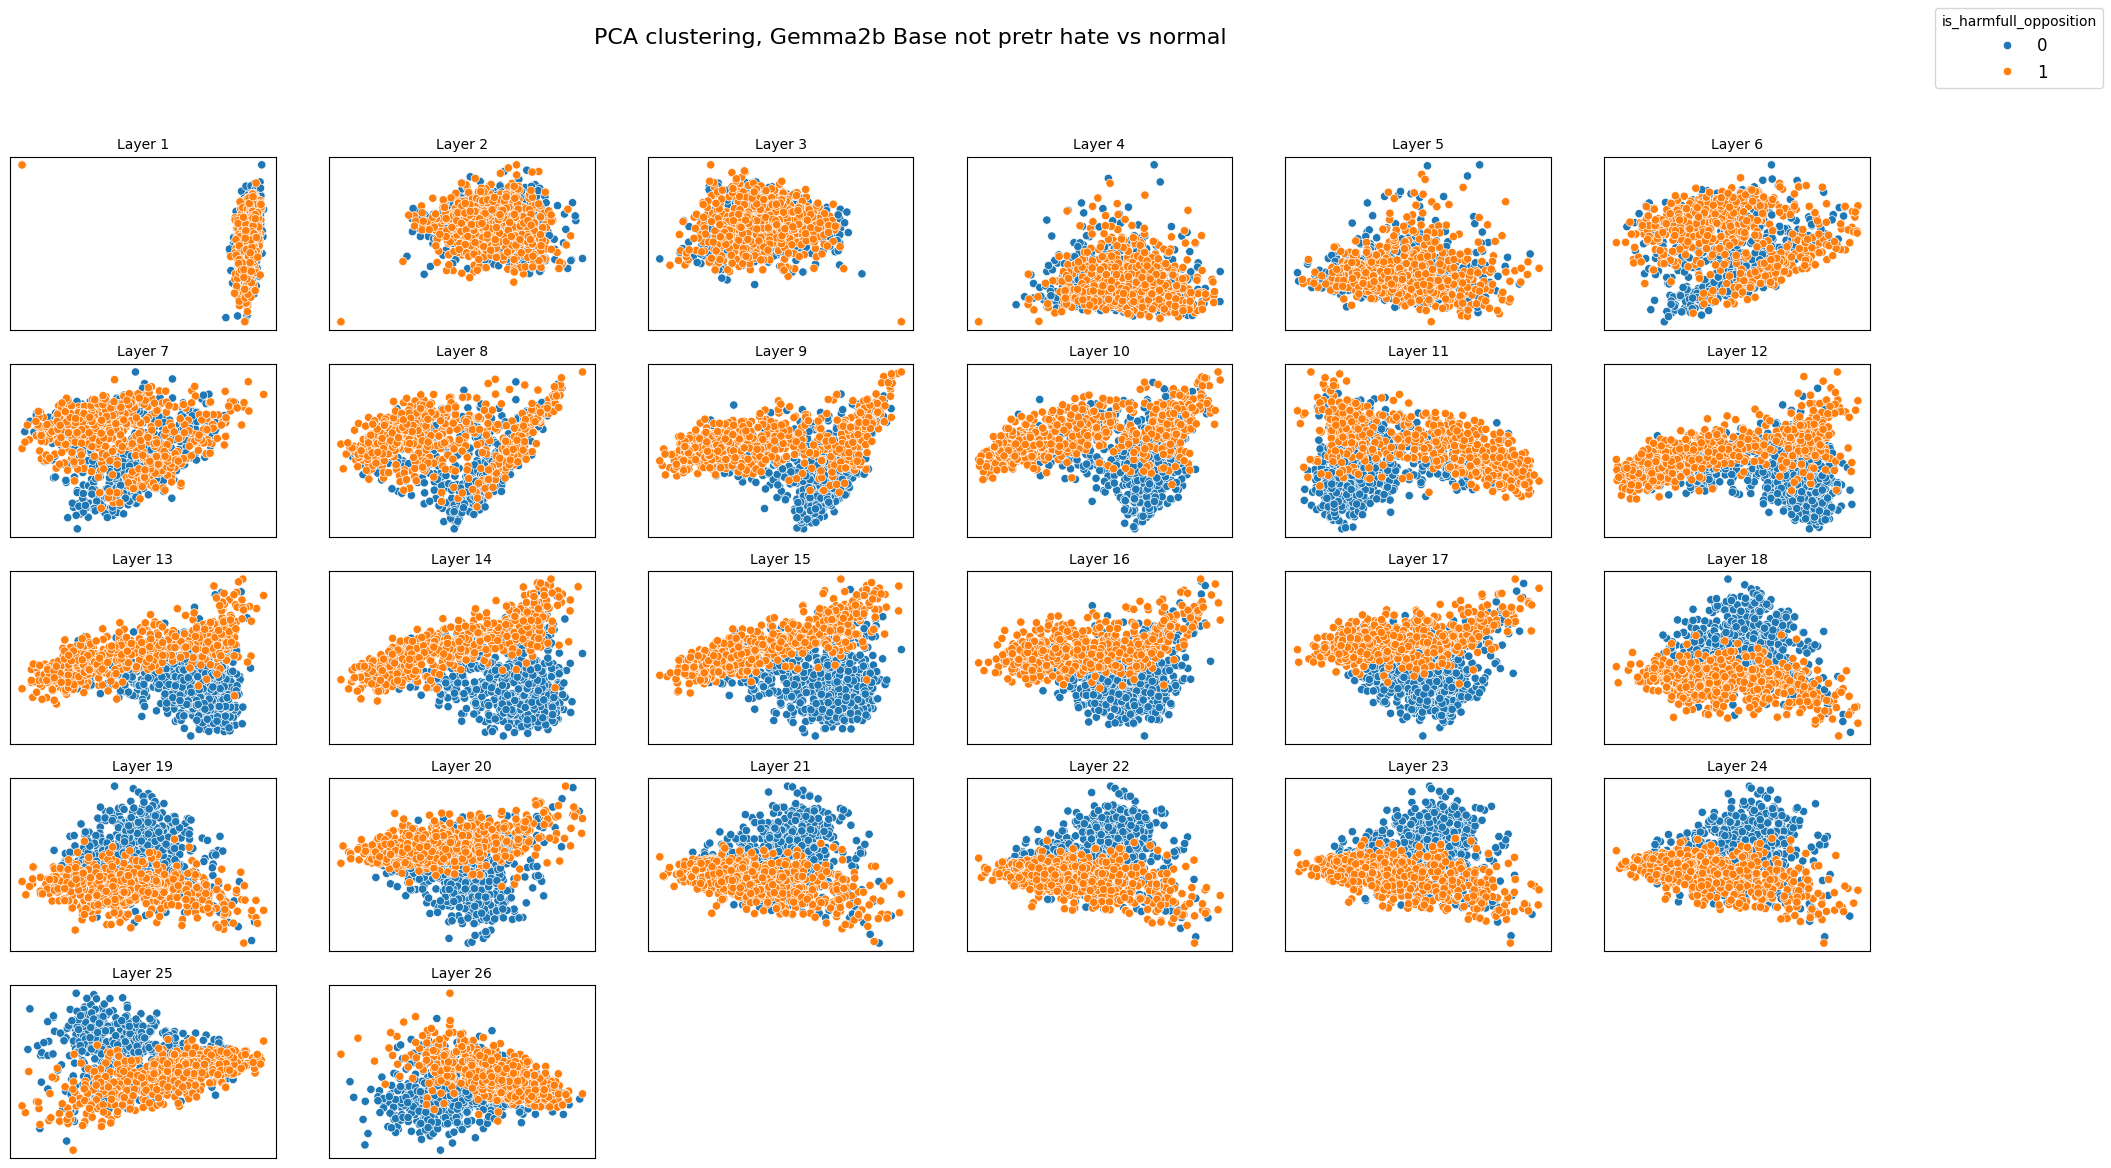

In [10]:
# Check data types and shapes first
print("X_pos dtype:", X_pos.dtype)
print("X_pos shape:", X_pos.shape)
print("X_neg dtype:", X_neg.dtype)
print("X_neg shape:", X_neg.shape)

print("######################################################################################## ")
print("X_pos.max()", X_pos.max())
print("X_pos.min()", X_pos.min())
print("X_pos.mean()", X_pos.mean())
print("X_pos.std()", X_pos.std())
print("X_pos.median()", np.median(X_pos))
print("X_neg.max()", X_neg.max())
print("X_neg.min()", X_neg.min())
print("X_neg.mean()", X_neg.mean())
print("X_neg.std()", X_neg.std())
print("X_neg.median()", np.median(X_neg))
print("######################################################################################## ")

# Check for any issues with the data
print("X_pos sample:", X_pos.flat[:5])
print("X_neg sample:", X_neg.flat[:5])

# Convert to proper numeric type if needed
X_pos = X_pos.astype(np.float32)
X_neg = X_neg.astype(np.float32)

n_samples, n_layers, n_features = X_pos.shape

# Normalize the data
X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)

print("Normalization completed!")
print("X_pos_normalized shape:", X_pos_normalized.shape)
print("X_neg_normalized shape:", X_neg_normalized.shape)

# Check data types and shapes first
print("X_pos_normalized dtype:", X_pos_normalized.dtype)
print("X_pos_normalized shape:", X_pos_normalized.shape)
print("X_neg_normalized dtype:", X_neg_normalized.dtype)
print("X_neg_normalized shape:", X_neg_normalized.shape)

print("######################################################################################## ")
print("X_pos_normalized.max()", X_pos_normalized.max())
print("X_pos_normalized.min()", X_pos_normalized.min())
print("X_pos_normalized.mean()", X_pos_normalized.mean())
print("X_pos_normalized.std()", X_pos_normalized.std())
print("X_pos_normalized.median()", np.median(X_pos_normalized))
print("X_neg_normalized.max()", X_neg_normalized.max())
print("X_neg_normalized.min()", X_neg_normalized.min())
print("X_neg_normalized.mean()", X_neg_normalized.mean())
print("X_neg_normalized.std()", X_neg_normalized.std())
print("X_neg_normalized.median()", np.median(X_neg_normalized))
print("######################################################################################## ")

# Verify normalization worked - check L2 norms
print("X_pos_normalized sample norms:", np.linalg.norm(X_pos_normalized.reshape(-1, n_features)[:5], axis=1))
print("X_neg_normalized sample norms:", np.linalg.norm(X_neg_normalized.reshape(-1, n_features)[:5], axis=1))

# Plot PCA
from format_results_fixed import plot_pca_or_tsne_layerwise
plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering, Gemma2b Base not pretr hate vs normal')

## **5. Find best CCS**


To find the best layers, train CCS on all hidden states. You can use different normalization strategies, the best in experiments was l2 + median.

In [11]:
from ccs import CCS, train_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.15, random_state=71, shuffle=True)


# train CCS on normalized states
orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

with open(f'ccs_{YOUR_NAME}_mixed_data_results.pkl', 'wb') as f:
    pickle.dump(orig_ccs, f)

Median normalize used
Layer 1/27, CCS accuracy: 0.5478723404255319
Median normalize used
Layer 2/27, CCS accuracy: 0.5319148936170213
Median normalize used
Layer 3/27, CCS accuracy: 0.5425531914893617
Median normalize used
Layer 4/27, CCS accuracy: 0.5372340425531915
Median normalize used
Layer 5/27, CCS accuracy: 0.5053191489361702
Median normalize used
Layer 6/27, CCS accuracy: 0.6223404255319149
Median normalize used
Layer 7/27, CCS accuracy: 0.7074468085106382
Median normalize used
Layer 8/27, CCS accuracy: 0.7021276595744681
Median normalize used
Layer 9/27, CCS accuracy: 0.7393617021276595
Median normalize used
Layer 10/27, CCS accuracy: 0.7393617021276595
Median normalize used
Layer 11/27, CCS accuracy: 0.7340425531914894
Median normalize used
Layer 12/27, CCS accuracy: 0.7446808510638299
Median normalize used
Layer 13/27, CCS accuracy: 0.7287234042553192
Median normalize used
Layer 14/27, CCS accuracy: 0.7393617021276596
Median normalize used
Layer 15/27, CCS accuracy: 0.75
Med

After that, we train the CCS on the selected layer to obtain the probe and its weights.

In [12]:
from ccs import CCS
import random

LAYER_IDX = 4

X_pos_normalized_data = pd.DataFrame(X_pos_normalized[:, LAYER_IDX])
X_neg_normalized_data = pd.DataFrame(X_neg_normalized[:, LAYER_IDX])


# Train-Test indexes
X_pos_norm_train = X_pos_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_pos_norm_test  = X_pos_normalized_data.loc[test_idx, :].values.astype(np.float32)

X_neg_norm_train = X_neg_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_neg_norm_test  = X_neg_normalized_data.loc[test_idx, :].values.astype(np.float32)

y_train = hate_data['is_harmfull_opposition'][train_idx]
y_test  = hate_data['is_harmfull_opposition'][test_idx]

# Median normalizing
X_pos_norm_train -= np.median(X_pos_norm_train)
X_pos_norm_test -= np.median(X_pos_norm_train)

X_neg_norm_train -= np.median(X_neg_norm_train)
X_neg_norm_test -= np.median(X_neg_norm_train)

# Train CCS without labels first NEG, after POS!
ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train.values, var_normalize=False, lambda_classification=0, predict_normalize=False)
ccs.repeated_train()

# Evaluate
ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
print("CCS accuracy: {}".format(ccs_acc))

CCS accuracy: 0.5265957446808511


I DON'T UNDERSTAND WHY THE ACCURACY IS DIFFERENT AND I DON'T SEE THE BUG AT ALL

# NOT

In [ ]:
# path to big hate data
hate_data = pd.read_csv('../data/raw/total_hate_not_data.csv', index_col=0)
hate_data.head(2)

hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total_not_yes_data.csv', index_col=0)
hate_total_no_data =  pd.read_csv('../data/yes_no/hate_total_not_no_data.csv', index_col=0)



from extract import vectorize_df, extract_representation

X_pos = vectorize_df(hate_total_yes_data['statement'],
                     gemma_model,
                     gemma_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

X_neg = vectorize_df(hate_total_no_data['statement'],
                     gemma_model,
                     gemma_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

np.savez_compressed(f'{YOUR_NAME}_neg_not.npz', X_neg)
np.savez_compressed(f'{YOUR_NAME}_pos_not.npz', X_pos)

# Load the files correctly
X_pos_file = np.load(f'{YOUR_NAME}_pos_not.npz')
X_neg_file = np.load(f'{YOUR_NAME}_neg_not.npz')

# Extract the actual arrays
X_pos = X_pos_file['arr_0']
X_neg = X_neg_file['arr_0']




# Check data types and shapes first
print("X_pos dtype:", X_pos.dtype)
print("X_pos shape:", X_pos.shape)
print("X_neg dtype:", X_neg.dtype)
print("X_neg shape:", X_neg.shape)

print("######################################################################################## ")
print("X_pos.max()", X_pos.max())
print("X_pos.min()", X_pos.min())
print("X_pos.mean()", X_pos.mean())
print("X_pos.std()", X_pos.std())
print("X_pos.median()", np.median(X_pos))
print("X_neg.max()", X_neg.max())
print("X_neg.min()", X_neg.min())
print("X_neg.mean()", X_neg.mean())
print("X_neg.std()", X_neg.std())
print("X_neg.median()", np.median(X_neg))
print("######################################################################################## ")

# Check for any issues with the data
print("X_pos sample:", X_pos.flat[:5])
print("X_neg sample:", X_neg.flat[:5])

# Convert to proper numeric type if needed
X_pos = X_pos.astype(np.float32)
X_neg = X_neg.astype(np.float32)

n_samples, n_layers, n_features = X_pos.shape

# Normalize the data
X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)

print("Normalization completed!")
print("X_pos_normalized shape:", X_pos_normalized.shape)
print("X_neg_normalized shape:", X_neg_normalized.shape)

# Check data types and shapes first
print("X_pos_normalized dtype:", X_pos_normalized.dtype)
print("X_pos_normalized shape:", X_pos_normalized.shape)
print("X_neg_normalized dtype:", X_neg_normalized.dtype)
print("X_neg_normalized shape:", X_neg_normalized.shape)

print("######################################################################################## ")
print("X_pos_normalized.max()", X_pos_normalized.max())
print("X_pos_normalized.min()", X_pos_normalized.min())
print("X_pos_normalized.mean()", X_pos_normalized.mean())
print("X_pos_normalized.std()", X_pos_normalized.std())
print("X_pos_normalized.median()", np.median(X_pos_normalized))
print("X_neg_normalized.max()", X_neg_normalized.max())
print("X_neg_normalized.min()", X_neg_normalized.min())
print("X_neg_normalized.mean()", X_neg_normalized.mean())
print("X_neg_normalized.std()", X_neg_normalized.std())
print("X_neg_normalized.median()", np.median(X_neg_normalized))
print("######################################################################################## ")

# Verify normalization worked - check L2 norms
print("X_pos_normalized sample norms:", np.linalg.norm(X_pos_normalized.reshape(-1, n_features)[:5], axis=1))
print("X_neg_normalized sample norms:", np.linalg.norm(X_neg_normalized.reshape(-1, n_features)[:5], axis=1))

# Plot PCA
from format_results_fixed import plot_pca_or_tsne_layerwise
plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering, DeBerta Base not pretr hate vs normal')




Extracting embeddings:  25%|██▌       | 317/1250 [00:21<01:02, 14.96it/s]

In [ ]:
from ccs import CCS, train_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.15, random_state=71, shuffle=True)


# train CCS on normalized states
orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')
with open(f'ccs_{YOUR_NAME}_not_data_results.pkl', 'wb') as f:
    pickle.dump(orig_ccs, f)
    


Median normalize used
Layer 1/27, CCS accuracy: 0.5478723404255319
Median normalize used
Layer 2/27, CCS accuracy: 0.5319148936170213
Median normalize used
Layer 3/27, CCS accuracy: 0.5691489361702128
Median normalize used
Layer 4/27, CCS accuracy: 0.5212765957446808
Median normalize used
Layer 5/27, CCS accuracy: 0.5053191489361702
Median normalize used
Layer 6/27, CCS accuracy: 0.5957446808510638
Median normalize used
Layer 7/27, CCS accuracy: 0.7127659574468085
Median normalize used
Layer 8/27, CCS accuracy: 0.7074468085106382
Median normalize used
Layer 9/27, CCS accuracy: 0.7393617021276595
Median normalize used
Layer 10/27, CCS accuracy: 0.7393617021276596
Median normalize used
Layer 11/27, CCS accuracy: 0.7393617021276595
Median normalize used
Layer 12/27, CCS accuracy: 0.7446808510638299
Median normalize used
Layer 13/27, CCS accuracy: 0.7340425531914894
Median normalize used
Layer 14/27, CCS accuracy: 0.7393617021276596
Median normalize used
Layer 15/27, CCS accuracy: 0.909574

In [ ]:
from ccs import CCS
import random

LAYER_IDX = 4

X_pos_normalized_data = pd.DataFrame(X_pos_normalized[:, LAYER_IDX])
X_neg_normalized_data = pd.DataFrame(X_neg_normalized[:, LAYER_IDX])


# Train-Test indexes
X_pos_norm_train = X_pos_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_pos_norm_test  = X_pos_normalized_data.loc[test_idx, :].values.astype(np.float32)

X_neg_norm_train = X_neg_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_neg_norm_test  = X_neg_normalized_data.loc[test_idx, :].values.astype(np.float32)

y_train = hate_data['is_harmfull_opposition'][train_idx]
y_test  = hate_data['is_harmfull_opposition'][test_idx]

# Median normalizing
X_pos_norm_train -= np.median(X_pos_norm_train)
X_pos_norm_test -= np.median(X_pos_norm_train)

X_neg_norm_train -= np.median(X_neg_norm_train)
X_neg_norm_test -= np.median(X_neg_norm_train)

# Train CCS without labels first NEG, after POS!
ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train.values, var_normalize=False, lambda_classification=0, predict_normalize=False)
ccs.repeated_train()

# Evaluate
ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
print("CCS accuracy: {}".format(ccs_acc))

CCS accuracy: 0.5159574468085106


# TTT

Extracting embeddings: 100%|██████████| 1250/1250 [01:49<00:00, 11.46it/s]


X_pos dtype: float32
X_pos shape: (1250, 27, 2304)
X_neg dtype: float32
X_neg shape: (1250, 27, 2304)
######################################################################################## 
X_pos.max() 335.9274
X_pos.min() -390.66632
X_pos.mean() 0.07216411
X_pos.std() 5.092995
X_pos.median() 0.004097782
X_neg.max() 316.13034
X_neg.min() -360.1894
X_neg.mean() 0.08164606
X_neg.std() 4.8618746
X_neg.median() 0.017212272
######################################################################################## 
X_pos sample: [-0.41606918  0.8024701  -1.5463089   2.3808136  -1.8874665 ]
X_neg sample: [-0.41606918  0.8024701  -1.5463089   2.3808136  -1.8874665 ]
Normalization completed!
X_pos_normalized shape: (1250, 27, 2304)
X_neg_normalized shape: (1250, 27, 2304)
X_pos_normalized dtype: float32
X_pos_normalized shape: (1250, 27, 2304)
X_neg_normalized dtype: float32
X_neg_normalized shape: (1250, 27, 2304)
################################################################################

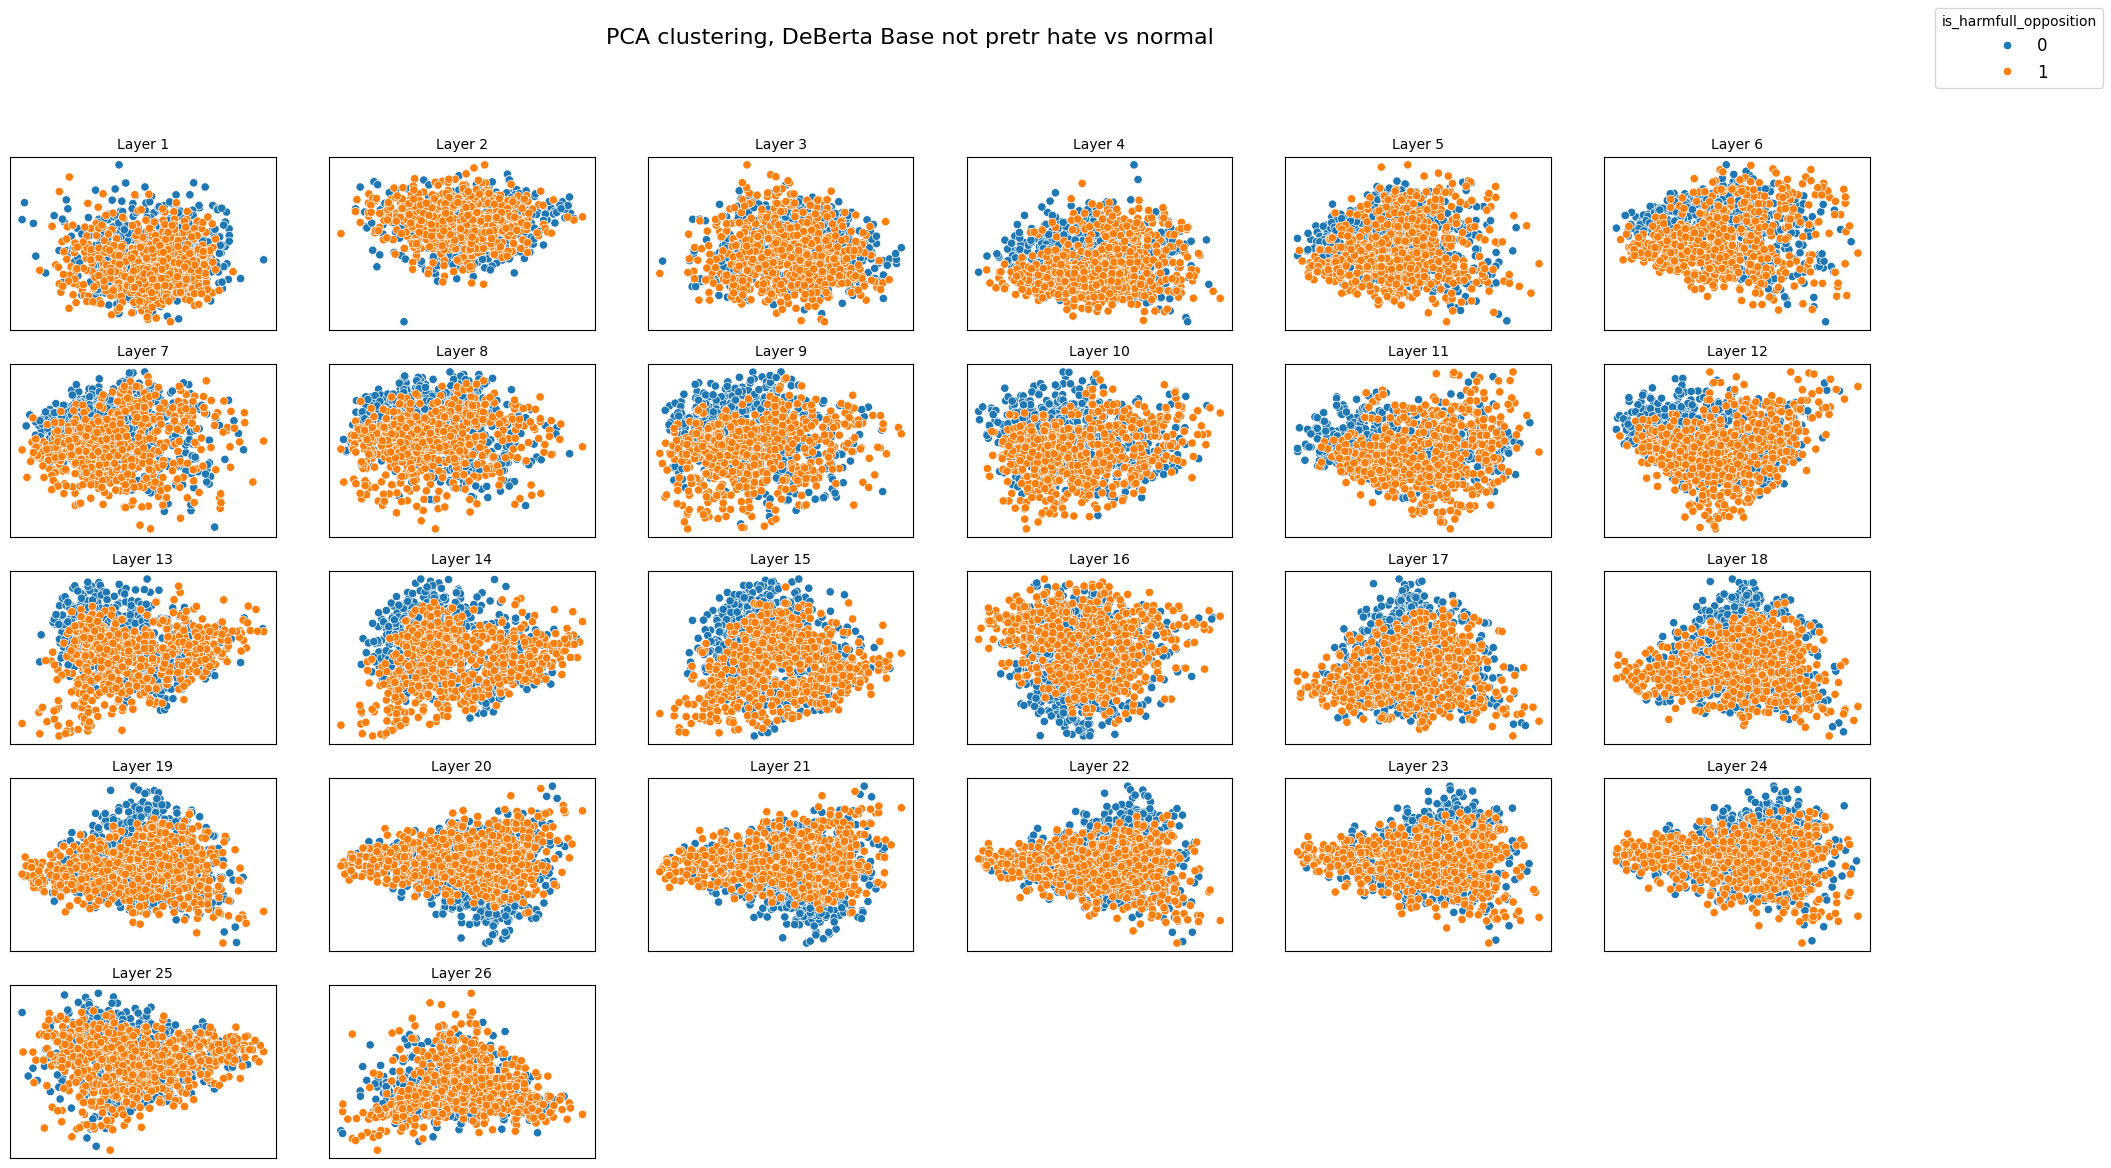

In [ ]:
# path to big hate data
hate_data = pd.read_csv('../data/raw/total_hate_not_data.csv', index_col=0)
hate_data.head(2)



hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total_not_yes_data.csv', index_col=0)
hate_total_no_data =  pd.read_csv('../data/yes_no/hate_total_not_no_data.csv', index_col=0)

hate_total_yes_data['statement'] = hate_total_yes_data['statement'].apply(
                                    lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))
hate_total_no_data['statement'] = hate_total_no_data['statement'].apply(
                                        lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))


from extract import vectorize_df, extract_representation

X_pos = vectorize_df(hate_total_yes_data['statement'],
                     gemma_model,
                     gemma_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

X_neg = vectorize_df(hate_total_no_data['statement'],
                     gemma_model,
                     gemma_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

np.savez_compressed(f'{YOUR_NAME}_neg_ttt.npz', X_neg)
np.savez_compressed(f'{YOUR_NAME}_pos_ttt.npz', X_pos)

# Load the files correctly
X_pos_file = np.load(f'{YOUR_NAME}_pos_ttt.npz')
X_neg_file = np.load(f'{YOUR_NAME}_neg_ttt.npz')

# Extract the actual arrays
X_pos = X_pos_file['arr_0']
X_neg = X_neg_file['arr_0']


# Check data types and shapes first
print("X_pos dtype:", X_pos.dtype)
print("X_pos shape:", X_pos.shape)
print("X_neg dtype:", X_neg.dtype)
print("X_neg shape:", X_neg.shape)

print("######################################################################################## ")
print("X_pos.max()", X_pos.max())
print("X_pos.min()", X_pos.min())
print("X_pos.mean()", X_pos.mean())
print("X_pos.std()", X_pos.std())
print("X_pos.median()", np.median(X_pos))
print("X_neg.max()", X_neg.max())
print("X_neg.min()", X_neg.min())
print("X_neg.mean()", X_neg.mean())
print("X_neg.std()", X_neg.std())
print("X_neg.median()", np.median(X_neg))
print("######################################################################################## ")

# Check for any issues with the data
print("X_pos sample:", X_pos.flat[:5])
print("X_neg sample:", X_neg.flat[:5])

# Convert to proper numeric type if needed
X_pos = X_pos.astype(np.float32)
X_neg = X_neg.astype(np.float32)

n_samples, n_layers, n_features = X_pos.shape

# Normalize the data
X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)

print("Normalization completed!")
print("X_pos_normalized shape:", X_pos_normalized.shape)
print("X_neg_normalized shape:", X_neg_normalized.shape)

# Check data types and shapes first
print("X_pos_normalized dtype:", X_pos_normalized.dtype)
print("X_pos_normalized shape:", X_pos_normalized.shape)
print("X_neg_normalized dtype:", X_neg_normalized.dtype)
print("X_neg_normalized shape:", X_neg_normalized.shape)

print("######################################################################################## ")
print("X_pos_normalized.max()", X_pos_normalized.max())
print("X_pos_normalized.min()", X_pos_normalized.min())
print("X_pos_normalized.mean()", X_pos_normalized.mean())
print("X_pos_normalized.std()", X_pos_normalized.std())
print("X_pos_normalized.median()", np.median(X_pos_normalized))
print("X_neg_normalized.max()", X_neg_normalized.max())
print("X_neg_normalized.min()", X_neg_normalized.min())
print("X_neg_normalized.mean()", X_neg_normalized.mean())
print("X_neg_normalized.std()", X_neg_normalized.std())
print("X_neg_normalized.median()", np.median(X_neg_normalized))
print("######################################################################################## ")

# Verify normalization worked - check L2 norms
print("X_pos_normalized sample norms:", np.linalg.norm(X_pos_normalized.reshape(-1, n_features)[:5], axis=1))
print("X_neg_normalized sample norms:", np.linalg.norm(X_neg_normalized.reshape(-1, n_features)[:5], axis=1))

# Plot PCA
from format_results_fixed import plot_pca_or_tsne_layerwise
plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering, DeBerta Base not pretr hate vs normal')




In [ ]:
from ccs import CCS, train_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.15, random_state=71, shuffle=True)


# train CCS on normalized states
orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')
with open(f'ccs_{YOUR_NAME}_ttt_data_results.pkl', 'wb') as f:
    pickle.dump(orig_ccs, f)
    


Median normalize used
Layer 1/27, CCS accuracy: 0.5478723404255319
Median normalize used
Layer 2/27, CCS accuracy: 0.5159574468085106
Median normalize used
Layer 3/27, CCS accuracy: 0.601063829787234
Median normalize used
Layer 4/27, CCS accuracy: 0.776595744680851
Median normalize used
Layer 5/27, CCS accuracy: 0.5106382978723404
Median normalize used
Layer 6/27, CCS accuracy: 0.574468085106383
Median normalize used
Layer 7/27, CCS accuracy: 0.7287234042553192
Median normalize used
Layer 8/27, CCS accuracy: 0.5797872340425532
Median normalize used
Layer 9/27, CCS accuracy: 0.648936170212766
Median normalize used
Layer 10/27, CCS accuracy: 0.6968085106382979
Median normalize used
Layer 11/27, CCS accuracy: 0.6914893617021277
Median normalize used
Layer 12/27, CCS accuracy: 0.5638297872340425
Median normalize used
Layer 13/27, CCS accuracy: 0.6117021276595744
Median normalize used
Layer 14/27, CCS accuracy: 0.5691489361702128
Median normalize used
Layer 15/27, CCS accuracy: 0.5691489361

KeyboardInterrupt: 

In [ ]:
from ccs import CCS
import random

LAYER_IDX = 4

X_pos_normalized_data = pd.DataFrame(X_pos_normalized[:, LAYER_IDX])
X_neg_normalized_data = pd.DataFrame(X_neg_normalized[:, LAYER_IDX])


# Train-Test indexes
X_pos_norm_train = X_pos_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_pos_norm_test  = X_pos_normalized_data.loc[test_idx, :].values.astype(np.float32)

X_neg_norm_train = X_neg_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_neg_norm_test  = X_neg_normalized_data.loc[test_idx, :].values.astype(np.float32)

y_train = hate_data['is_harmfull_opposition'][train_idx]
y_test  = hate_data['is_harmfull_opposition'][test_idx]

# Median normalizing
X_pos_norm_train -= np.median(X_pos_norm_train)
X_pos_norm_test -= np.median(X_pos_norm_train)

X_neg_norm_train -= np.median(X_neg_norm_train)
X_neg_norm_test -= np.median(X_neg_norm_train)

# Train CCS without labels first NEG, after POS!
ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train.values, var_normalize=False, lambda_classification=0, predict_normalize=False)
ccs.repeated_train()

# Evaluate
ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
print("CCS accuracy: {}".format(ccs_acc))

# **6. Steering**

In [ ]:
from steering_gemma import plot_steering_power, plot_boundary
from steering_gemma import PatchHook


In [ ]:
deltas = np.linspace(-0.05, 0.05, 30)

X_pos_tensor = torch.tensor(X_pos_normalized[:257], dtype=torch.float32, device=ccs.device)
X_neg_tensor = torch.tensor(X_neg_normalized[:257], dtype=torch.float32, device=ccs.device)

plot_steering_power(ccs, X_pos_tensor, X_neg_tensor, deltas, labels=["POS (statement + ДА) [harm]", "NEG (statement + НЕТ) [harm]"], 
                    title="Steering along opinion direction [harm]")

In [ ]:
deltas = np.linspace(-0.05, 0.05, 30)

X_pos_tensor = torch.tensor(X_pos_normalized[257:], dtype=torch.float32, device=ccs.device)
X_neg_tensor = torch.tensor(X_neg_normalized[257:], dtype=torch.float32, device=ccs.device)

plot_steering_power(ccs, X_pos_tensor, X_neg_tensor, deltas, labels=["POS (statement + ДА) [safe]", "NEG (statement + НЕТ) [safe]"], 
                    title="Steering along opinion direction [harm]")

Manual calibration

In [ ]:
idx = 1  # first sample
h_orig = torch.tensor(X_pos_normalized_data.loc[idx], dtype=torch.float32, device=ccs.device)

# ensure weights is numpy array and normalized
weights, _ = ccs.get_weights()

direction = weights / (np.linalg.norm(weights) + 1e-6)
h_steered =h_orig + 0.025*direction

p_orig = ccs.best_probe(h_orig.unsqueeze(0)).item()
p_steered = ccs.best_probe(h_steered.unsqueeze(0)).item()

print(f"Original: {p_orig:.4f}, Steered: {p_steered:.4f}")

In [ ]:

plot_boundary(
    X_pos_normalized_data, 
    X_neg_normalized_data,  
    hate_data['is_harmfull_opposition'], 
    ccs, 
    3, 
    [0, 1]
)

# 6.1. Steering

Very important: `alpha_neg = -alpha_pos`

In [ ]:
# CHANGED: Use create_steering_direction function to keep all operations on GPU
from steering_gemma import create_steering_direction, prepare_gemma_inputs


direction = create_steering_direction(ccs, device="cuda" if torch.cuda.is_available() else "cpu")

alpha = 0.049
token_idx = 0
LAYER_IDX = 4

true = hate_data['is_harmfull_opposition'] 
texts = hate_data['statement']
text_yes = texts + " Yes."

# CHANGED: Use prepare_gemma_inputs function for GPU optimization
inputs_yes = prepare_gemma_inputs(text_yes, gemma_tokenizer, device=direction.device)

true_tensor = torch.tensor(true.values, dtype=torch.long, device=direction.device)

# CHANGED: Ensure model is on GPU
gemma_model = gemma_model.to(direction.device)

# Создаём и настраиваем hook_obj
hook_obj = PatchHook(token_idx=token_idx,     # which token to adjust
                     direction=direction,      # CCS vector weights (normalize before)
                     character=true_tensor,    # y tensor
                     alpha=alpha)              # steering coef

print(f"[MAIN] hook_obj id: {id(hook_obj)}")
print(f"[MAIN] character shape: {hook_obj.character.shape}")

# CHANGED: Hook to correct Gemma2 layer - use model.model.layers instead of deberta.encoder.layer
h = gemma_model.model.layers[LAYER_IDX].register_forward_hook(hook_obj)

# Прогон
with torch.no_grad():
    outputs_patched_yes = gemma_model(**inputs_yes, output_hidden_states=True)

h.remove()

print("[MAIN] Patching completed successfully!")
print(f"[MAIN] Output shape: {outputs_patched_yes.logits.shape}")

In [ ]:
# Removing hooks   

def remove_all_forward_hooks(model):
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_forward_hooks"):
                child._forward_hooks.clear()
            remove_all_forward_hooks(child)
    
def remove_all_backward_hooks(model):
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_backward_hooks"):
                child._backward_hooks.clear()
            remove_all_backward_hooks(child)


In [ ]:
remove_all_forward_hooks(gemma_model)
gemma_model.model.layers[LAYER_IDX]._forward_hooks.clear()

Negative texts with `-1*alpha`

In [ ]:
# Negative texts
text_no = texts + " No."
inputs_no = gemma_tokenizer(list(text_no), return_tensors="pt", padding=True)
inputs_no = {k: v.to(direction.device) for k, v in inputs_no.items()}

# Hook
hook_obj2 = PatchHook(token_idx=token_idx, direction=direction, character=true_tensor, alpha=-1*alpha)


h = gemma_model.model.layers[LAYER_IDX].output.register_forward_hook(hook_obj2)

# Run
with torch.no_grad():
    outputs_patched_no = gemma_model(**inputs_no, output_hidden_states=True)

# **7. PCA results and steered probe**

In [ ]:
X_pos_st = np.array(outputs_patched_yes.hidden_states)[:, :, 0, :].transpose(1, 0, 2)
X_neg_st = np.array(outputs_patched_no.hidden_states)[:, :, 0, :].transpose(1, 0, 2)

In [ ]:
X_pos_st_norm = normalize(X_pos_st[:, LAYER_IDX, :], norm='l2', axis=1)
X_neg_st_norm = normalize(X_neg_st[:, LAYER_IDX, :], norm='l2', axis=1)

classes_st, probas_st = ccs.predict(X_pos_st_norm, X_neg_st_norm)
classes_or, probas_or = ccs.predict(X_neg_normalized[:, LAYER_IDX, :], X_pos_normalized[:, LAYER_IDX, :])

In [ ]:
X_pos_st_normalized = X_pos_st.reshape(-1, X_pos_st.shape[-1])         # (512*25, 768)
X_pos_st_normalized = normalize(X_pos_st_normalized, norm='l2', axis=1).reshape(X_pos_st.shape)

X_neg_st_normalized = X_neg_st.reshape(-1, X_neg_st.shape[-1])         # (512*25, 768)
X_neg_st_normalized = normalize(X_neg_st_normalized, norm='l2', axis=1).reshape(X_neg_st.shape)

# Components 1, 3

plot_pca_or_tsne_layerwise(X_pos_st_normalized,
                           X_neg_st_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False,
                           n_components=5, components=[1, 3])

In [ ]:
# Components 1, 0
plot_pca_or_tsne_layerwise(X_pos_st_normalized,
                           X_neg_st_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False,
                           n_components=5, components=[0, 1])

In [ ]:
steered_ccs = train_ccs_on_hidden_states(X_pos_st_normalized,
                                        X_neg_st_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

## **7. Plot results tables.**

In [ ]:
from format_results import get_results_table
orig_ccs_data = get_results_table(orig_ccs)
st_ccs_data = get_results_table(steered_ccs)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['accuracy'], label='Orig_CCS')
plt.plot(st_ccs_data['accuracy'], label='St_CCS')

plt.hlines(1, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('accuracy score ')
plt.legend(loc='upper right');

In [ ]:
from format_results import get_results_table
orig_ccs_data = get_results_table(orig_ccs)
st_ccs_data = get_results_table(steered_ccs)

fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['contradiction idx ↓'], label='Orig_CCS')
plt.plot(st_ccs_data['contradiction idx ↓'], label='St_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Contradiction idx score ')
plt.legend(loc='upper right');

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['agreement_score ↓'], label='Orig_CCS')
plt.plot(st_ccs_data['agreement_score ↓'], label='St_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Agreement score ')
plt.legend(loc='upper right');